# Hotel Minibar Project



### Instrucciones rápidas
1) Sube el CSV adjunto en el github
2) Run all cells

## 0) Imports

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, io, json
import statsmodels.formula.api as smf
from pathlib import Path
plt.rcParams['figure.figsize']=(9,5)
np.set_printoptions(suppress=True)

## 1) Cargar CSV

In [ ]:
try:
    from google.colab import files  # type: ignore
    IN_COLAB=True
except Exception:
    IN_COLAB=False

TARGET = '/content/hotel_minibar_DiD_realistic_v3.csv'  # cambia si quieres otro nombre
GENERATE_IF_MISSING = False  # pon True si quieres generar el dataset automáticamente

def read_csv_robust(path):
    # detect ipynb mis-upload
    if str(path).lower().endswith('.ipynb'):
        raise ValueError('Has subido un .ipynb. Sube un .csv con columnas: date,treat_date,...')
    # try standard CSV
    try:
        df = pd.read_csv(path, parse_dates=['date','treat_date'])
        return df
    except Exception as e1:
        # try ES locale
        try:
            df = pd.read_csv(path, sep=';', decimal=',', parse_dates=['date','treat_date'])
            return df
        except Exception as e2:
            # if file looks like ipynb JSON
            try:
                with open(path,'r',encoding='utf-8') as fh:
                    head = fh.read(2000)
                if 'nbformat' in head and 'cells' in head:
                    raise ValueError('El archivo parece un cuaderno .ipynb, no un CSV. Sube el CSV correcto.')
            except Exception:
                pass
            raise e2

def normalize_numeric(df):
    num_cols = ['rooms_available','rooms_sold','occ','adr','room_revenue','minibar_units',
                'minibar_rev','minibar_cogs','margin','share_new','direct_web_share','corporate_share']
    for c in num_cols:
        if c in df.columns and df[c].dtype=='object':
            s = (df[c].astype(str).str.replace(' ', '', regex=False)
                              .str.replace('%','', regex=False)
                              .str.replace(',', '.', regex=False))
            df[c] = pd.to_numeric(s, errors='coerce')
    # cast integer-like
    for c in ['rooms_available','rooms_sold','minibar_units']:
        if c in df.columns:
            df[c] = df[c].round().astype('Int64')
    # occ recompute if missing
    if 'occ' in df.columns and df['occ'].isna().any():
        df['occ'] = (df['rooms_sold']/df['rooms_available']).round(4)
    return df

def generate_realistic():
    rng = np.random.default_rng(2025)
    start = pd.Timestamp('2024-03-01'); end = pd.Timestamp('2024-08-31')
    dates = pd.date_range(start, end, freq='D')
    n_hotels, n_mad = 100, 12
    hotel_ids = [f'H{str(i).zfill(3)}' for i in range(1, n_hotels+1)]
    cities_pool = ['Madrid','Barcelona','Valencia','Sevilla','Bilbao','Málaga','Zaragoza','Alicante','Murcia','Valladolid','A Coruña','Granada','Córdoba']
    cities = ['Madrid']*n_mad + list(rng.choice([c for c in cities_pool if c!='Madrid'], size=n_hotels-n_mad, replace=True))
    rooms_available = rng.integers(90, 260, size=n_hotels)
    treat_date = pd.Timestamp('2024-06-15')
    treated_flags = np.array([1 if c=='Madrid' else 0 for c in cities])
    city_occ_base = {c: rng.uniform(0.55, 0.82) for c in set(cities)}
    city_adr_base = {c: rng.normal(110, 12) for c in set(cities)}
    city_minibar_spend_per_occ = {c: rng.uniform(2.7, 6.0) for c in set(cities)}
    rows=[]
    for i, hid in enumerate(hotel_ids):
        city = cities[i]; cap = rooms_available[i]
        occ_hotel_adj = rng.normal(0.0, 0.03); adr_hotel_adj = rng.normal(0.0, 7.0); spend_adj = rng.normal(0.0, 0.35)
        for t, d in enumerate(dates):
            week = np.sin(2*np.pi*(t/7)); summer = 0.07 if d.month in [6,7,8] else 0.0
            occ = city_occ_base[city] + occ_hotel_adj + 0.04*week + summer + rng.normal(0, 0.02)
            occ = float(np.clip(occ, 0.35, 0.98))
            adr = city_adr_base[city] + adr_hotel_adj + 6*np.sin(2*np.pi*(t/30)) + rng.normal(0, 3.0)
            adr = float(max(60, adr))
            rooms_sold = int(round(occ * cap))
            room_revenue = rooms_sold * adr
            spend_per_occ = city_minibar_spend_per_occ[city] + spend_adj + 0.2*np.sin(2*np.pi*(t/14)) + rng.normal(0, 0.22)
            spend_per_occ = max(1.5, spend_per_occ)
            minibar_rev = rooms_sold * spend_per_occ
            item_price = rng.uniform(2.5, 4.5)
            minibar_units = int(round(minibar_rev / item_price))
            is_treated = treated_flags[i]==1
            if is_treated and d >= treat_date:
                days_since = (d - treat_date).days
                share_new = 1/(1+np.exp(-0.18*(days_since-10)))
            else:
                share_new = 0.0
            base_margin_rate = 0.45; uplift_rate = 0.12
            margin_rate = base_margin_rate + uplift_rate*share_new
            minibar_margin = minibar_rev * margin_rate
            minibar_cogs   = minibar_rev - minibar_margin
            direct_web_share = float(np.clip(rng.normal(0.35, 0.08), 0.05, 0.80))
            corporate_share  = float(np.clip(rng.normal(0.18, 0.06), 0.00, 0.60))
            rows.append(dict(hotel_id=hid, city=city, date=d, rooms_available=cap, rooms_sold=rooms_sold,
                              occ=occ, adr=adr, room_revenue=room_revenue, minibar_units=minibar_units,
                              minibar_rev=minibar_rev, minibar_cogs=minibar_cogs, margin=minibar_margin,
                              treated=int(is_treated), treat_date=treat_date if is_treated else pd.NaT,
                              share_new=share_new, direct_web_share=direct_web_share, corporate_share=corporate_share))
    dfg = pd.DataFrame(rows)
    dfg.to_csv(TARGET, index=False)
    return dfg

# Try load
if Path(TARGET).exists():
    df = read_csv_robust(TARGET)
else:
    if IN_COLAB:
        print('Sube tu CSV (no .ipynb). Si usas formato ES, también sirve. Luego ejecute de nuevo esta celda si hace falta.')
        uploaded = files.upload()
        key = list(uploaded.keys())[0]
        df = read_csv_robust(key)
    else:
        if GENERATE_IF_MISSING:
            print('Generando dataset realista porque no se encontró CSV...')
            df = generate_realistic()
        else:
            raise FileNotFoundError('No se encontró CSV y GENERATE_IF_MISSING=False. Sube el CSV o active la generación.')

# Normalize numerics
def normalize_numeric(df):
    num_cols = ['rooms_available','rooms_sold','occ','adr','room_revenue','minibar_units',
                'minibar_rev','minibar_cogs','margin','share_new','direct_web_share','corporate_share']
    for c in num_cols:
        if c in df.columns and df[c].dtype=='object':
            s = (df[c].astype(str).str.replace(' ', '', regex=False)
                              .str.replace('%','', regex=False)
                              .str.replace(',', '.', regex=False))
            df[c] = pd.to_numeric(s, errors='coerce')
    for c in ['rooms_available','rooms_sold','minibar_units']:
        if c in df.columns:
            df[c] = df[c].round().astype('Int64')
    if 'occ' in df.columns and df['occ'].isna().any():
        df['occ'] = (df['rooms_sold']/df['rooms_available']).round(4)
    return df

df = normalize_numeric(df)
display(df.head())
df.dtypes

Sube tu CSV (no .ipynb). Si usas formato ES, también sirve. Luego ejecute de nuevo esta celda si hace falta.


Saving Leanalytics - 022 - Hoja 1 (1).csv to Leanalytics - 022 - Hoja 1 (1).csv


,hotel_id,city,date,rooms_available,rooms_sold,occ,adr,room_revenue,minibar_units,minibar_rev,minibar_cogs,margin,treated,treat_date,share_new,direct_web_share,corporate_share
0,H001,Madrid,2024-03-01,118,71,0.597862,131.526361,9338.371621,81,212.063679,116.635023,95.428656,1,2024-06-15,0.0,0.444256,0.163333
1,H001,Madrid,2024-03-02,118,74,0.626127,140.105785,10367.828082,47,209.307542,115.119148,94.188394,1,2024-06-15,0.0,0.443129,0.073555
2,H001,Madrid,2024-03-03,118,81,0.687121,137.439490,11132.598696,66,257.428760,141.585818,115.842942,1,2024-06-15,0.0,0.403476,0.147251
3,H001,Madrid,2024-03-04,118,78,0.661858,136.500592,10647.046176,61,208.363016,114.599659,93.763357,1,2024-06-15,0.0,0.396339,0.202051
4,H001,Madrid,2024-03-05,118,73,0.617881,143.717369,10491.367920,48,212.212758,116.717017,95.495741,1,2024-06-15,0.0,0.266053,0.096660


,0
hotel_id,object
city,object
date,datetime64[ns]
rooms_available,Int64
rooms_sold,Int64
occ,float64
adr,float64
room_revenue,float64
minibar_units,Int64
minibar_rev,float64


## 2) Sanity checks (Nans, missing values...)

In [ ]:
print('Fechas:', df['date'].min().date(), '→', df['date'].max().date())
print('Hoteles:', df['hotel_id'].nunique(), ' · Ciudades:', df['city'].nunique())
print('\nNulos por columna:')
print(df.isna().sum().sort_values(ascending=False).head(12))

occ_calc = (df['rooms_sold'].astype(float)/df['rooms_available'].astype(float)).round(4)
diff = occ_calc - df['occ'].astype(float)
print('\nΔ occ (calc - occ) [p5, p50, p95]:', np.percentile(diff.dropna(), [5,50,95]))

Fechas: 2024-03-01 → 2024-08-31
Hoteles: 100  · Ciudades: 13

Nulos por columna:
treat_date         16192
hotel_id               0
city                   0
rooms_available        0
date                   0
occ                    0
adr                    0
room_revenue           0
rooms_sold             0
minibar_units          0
minibar_rev            0
margin                 0
dtype: int64

Δ occ (calc - occ) [p5, p50, p95]: [-0.00300224  0.00000799  0.00298881]


## 3) Definir tratamiento y ventanas PRE/POST

In [ ]:
df['post'] = ((df['date']>=df['treat_date']) & (df['treated']==1)).astype(int)
df['D']    = df['treated']*df['post']
ref_date   = df.loc[df['treated']==1,'treat_date'].dropna().median()
print('treat_date (mediana):', ref_date.date())

treat_date (mediana): 2024-06-15


## 4) Matching PRE (features, distancias, pesos)

In [ ]:
# 4) Matching PRE (versión robusta): centroid de Madrid + softmax + cap de concentración
USE_OCC_ADR_FEATURES = True     # usa rasgos PRE de occ/adr (medias y pendientes)
TAU_SCALE = 0.75                # temperatura de softmax: 0.5–1.0 suele ir bien (↑TAU => pesos más repartidos)
CAP = 0.06                      # ningún donante puede pesar > 6%
MIN_DONORS = 25                 # como mínimo 25 hoteles en el control ponderado

pre = df[df['date'] < ref_date].copy()

def hotel_features_pre(sub):
    s = sub.sort_values('date')
    y = s['margin'].values
    t = np.arange(len(s))
    # Rasgos sobre el outcome (margin)
    slope = np.polyfit(t, y, 1)[0] if len(s) > 1 else 0.0
    mean  = float(np.mean(y)) if len(y) > 0 else 0.0
    std   = float(np.std(y))  if len(y) > 1 else 0.0
    s['dow'] = s['date'].dt.dayofweek
    wk = s.groupby('dow')['margin'].mean()
    week_amp = float(wk.loc[[0,1,2,3,4]].mean() - wk.loc[[5,6]].mean()) if wk.shape[0] == 7 else 0.0
    feats = {'mean_pre': mean, 'slope_pre': slope, 'std_pre': std, 'week_amp_pre': week_amp}
    # Rasgos PRE de occ/adr
    if USE_OCC_ADR_FEATURES:
        occ_mean  = s['occ'].mean()
        adr_mean  = s['adr'].mean()
        occ_slope = np.polyfit(t, s['occ'].values, 1)[0] if len(s) > 1 else 0.0
        adr_slope = np.polyfit(t, s['adr'].values, 1)[0] if len(s) > 1 else 0.0
        feats.update({'occ_mean_pre': occ_mean, 'occ_slope_pre': occ_slope,
                      'adr_mean_pre': adr_mean, 'adr_slope_pre': adr_slope})
    return pd.Series(feats)

ftrs = (pre.groupby('hotel_id', group_keys=False)
          .apply(hotel_features_pre)
          .reset_index())
ftrs = ftrs.merge(df[['hotel_id','city']].drop_duplicates(), on='hotel_id', how='left')

# Conjunto y pesos de rasgos
base_cols = ['mean_pre','slope_pre','std_pre','week_amp_pre']
base_w    = np.array([2.0, 5.0, 1.0, 1.0])  # más peso a la TENDENCIA del margen
if USE_OCC_ADR_FEATURES:
    cols = base_cols + ['occ_mean_pre','occ_slope_pre','adr_mean_pre','adr_slope_pre']
    wvec = np.array(list(base_w) + [1.0, 2.0, 1.0, 2.0])   # algo de peso a pendientes de occ/adr
else:
    cols, wvec = base_cols, base_w

# Estandarizar rasgos
fstd = ftrs.copy()
for c in cols:
    mu, sd = fstd[c].mean(), (fstd[c].std() if fstd[c].std() > 0 else 1.0)
    fstd[c] = (fstd[c] - mu) / sd

# 1) Centroid PRE de Madrid
mad   = fstd[fstd['city']=='Madrid'][cols].mean(axis=0).values
pool  = fstd[fstd['city']!='Madrid'].copy()

# 2) Distancia ponderada al centroid (cada control a Madrid-agregado)
diff   = (pool[cols].values - mad) * wvec
dist   = np.sqrt(np.sum(diff**2, axis=1))              # L2 ponderada
pool   = pool.assign(dist=dist)

# 3) Softmax de similitud (positivos y repartidos)
tau = np.quantile(pool['dist'], TAU_SCALE)             # escala la “temperatura”
scores = -pool['dist'].values / max(tau, 1e-6)         # más cerca => mayor score
w_soft = np.exp(scores - scores.max())                 # estabilidad numérica
w_soft = w_soft / w_soft.sum()

# 4) Asegurar diversidad: cap + al menos MIN_DONORS
order = np.argsort(-w_soft)                # de mayor a menor
w_capped = np.zeros_like(w_soft)
mass = 1.0
donors = 0
for idx in order:
    take = min(CAP, mass/(MIN_DONORS - donors)) if donors < MIN_DONORS else CAP
    wi = min(w_soft[idx], take)
    w_capped[idx] = wi
    mass -= wi
    donors += 1
    if mass <= 1e-12: break
if mass > 1e-12:  # redistribuir residuo proporcional en los que no alcanzaron CAP
    remaining = (w_capped < CAP)
    w_capped[remaining] += mass * (w_capped[remaining] / w_capped[remaining].sum())
w_final = w_capped / w_capped.sum()

control_weights = (pool[['hotel_id']].copy()
                     .assign(weight=w_final)
                     .sort_values('weight', ascending=False)
                     .reset_index(drop=True))

print('Número de donantes en el control ponderado:', (control_weights['weight']>0).sum())
print('Peso máximo:', round(float(control_weights['weight'].max()), 4))
display(control_weights.head(15))


Número de donantes en el control ponderado: 88
Peso máximo: 0.0178


/tmp/ipython-input-1680129498.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(hotel_features_pre)


,hotel_id,weight
0,H078,0.017760
1,H026,0.017482
2,H096,0.017226
3,H099,0.016836
4,H056,0.016369
5,H064,0.015822
6,H058,0.015821
7,H063,0.015720
8,H038,0.015708
9,H079,0.015562


## 5) Chequeo PRE: Madrid vs Control ponderado

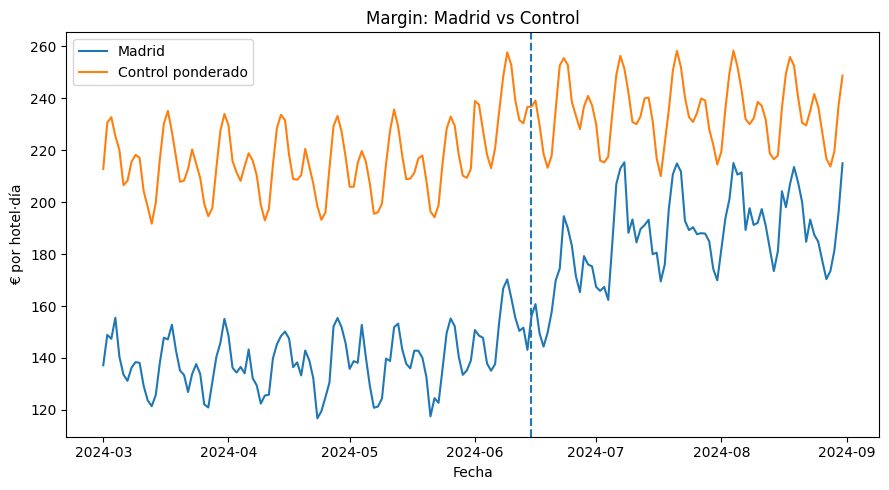

In [ ]:
mad_series=(df[df['city']=='Madrid'].groupby('date', as_index=False)['margin'].mean())
ctrl_series=(df[df['hotel_id'].isin(set(control_weights['hotel_id']))]
             .merge(control_weights, on='hotel_id', how='left')
             .assign(wy=lambda x: x['margin']*x['weight'])
             .groupby('date', as_index=False)['wy'].sum().rename(columns={'wy':'margin'}))
plt.figure(); plt.plot(mad_series['date'], mad_series['margin'], label='Madrid')
plt.plot(ctrl_series['date'], ctrl_series['margin'], label='Control ponderado')
plt.axvline(ref_date, linestyle='--'); plt.title('Margin: Madrid vs Control')
plt.xlabel('Fecha'); plt.ylabel('€ por hotel·día'); plt.legend(); plt.tight_layout(); plt.show()

## 6) Pre‑trends (solo PRE)

In [ ]:
def slope(y):
    t=np.arange(len(y)); return np.polyfit(t,y,1)[0] if len(y)>1 else 0.0
m_pre=mad_series[mad_series['date']<ref_date]
c_pre=ctrl_series[ctrl_series['date']<ref_date]
pre_df=m_pre.rename(columns={'margin':'m_mad'}).merge(c_pre.rename(columns={'margin':'m_ctrl'}), on='date')
pre_df=pre_df.sort_values('date').reset_index(drop=True)
pre_df['t']=np.arange(len(pre_df))
res_pre=smf.ols('(m_mad - m_ctrl) ~ t', data=pre_df).fit()
print(res_pre.summary())
print('Pendiente PRE Madrid:', slope(m_pre['margin'].values))
print('Pendiente PRE Control:', slope(c_pre['margin'].values))

                            OLS Regression Results                            
Dep. Variable:                  m_mad   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     8.106
Date:                Sat, 29 Nov 2025   Prob (F-statistic):            0.00532
Time:                        11:28:09   Log-Likelihood:                -400.10
No. Observations:                 106   AIC:                             804.2
Df Residuals:                     104   BIC:                             809.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    134.1045      2.053     65.307      0.0

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -75.7696      1.050    -72.150      0.000     -77.828     -73.711
t             -0.0309      0.025     -1.237      0.216      -0.080       0.018
Pendiente gap PRE: -0.0309  |  p-valor: 0.216


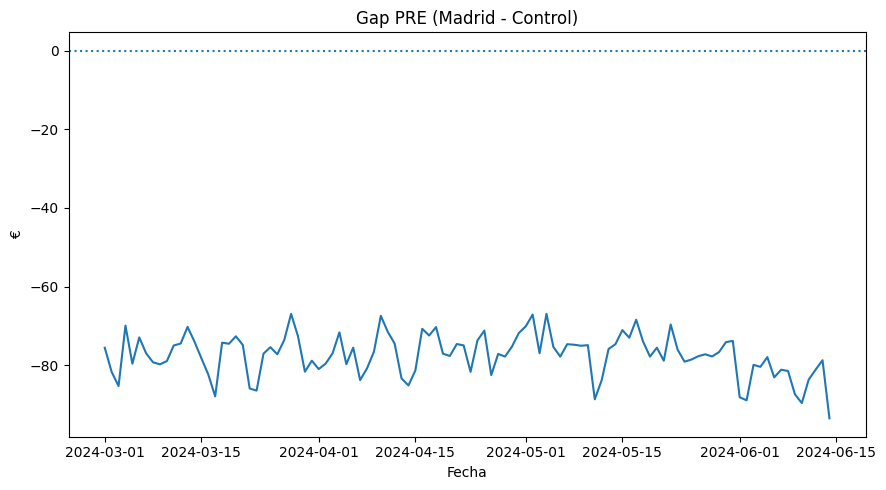

In [ ]:
# --- Chequeo PRE sobre la diferencia (Madrid - Control) con HAC ---
import statsmodels.api as sm

m_pre = mad_series[mad_series['date'] < ref_date].rename(columns={'margin':'m_mad'})
c_pre = ctrl_series[ctrl_series['date'] < ref_date].rename(columns={'margin':'m_ctrl'})
pre_df = (m_pre.merge(c_pre, on='date')
                .sort_values('date')
                .assign(gap=lambda x: x['m_mad'] - x['m_ctrl'],
                        t=lambda x: np.arange(len(x))))

X = sm.add_constant(pre_df['t'])
mod = sm.OLS(pre_df['gap'], X).fit(cov_type='HAC', cov_kwds={'maxlags':7})
print(mod.summary().tables[1])
print(f"Pendiente gap PRE: {mod.params['t']:.4f}  |  p-valor: {mod.pvalues['t']:.3f}")

# Visual rápido: gap PRE
plt.figure()
plt.plot(pre_df['date'], pre_df['gap'])
plt.axhline(0, ls=':')
plt.title('Gap PRE (Madrid - Control)')
plt.xlabel('Fecha'); plt.ylabel('€'); plt.tight_layout(); plt.show()


## 7) Muestra analítica + pesos

In [ ]:
work=df[(df['city']=='Madrid') | (df['hotel_id'].isin(set(control_weights['hotel_id'])))].copy()
work=work.merge(control_weights, on='hotel_id', how='left')
work['weight']=work['weight'].fillna(1.0/df.loc[df['city']=='Madrid','hotel_id'].nunique())
work.head()

,hotel_id,city,date,rooms_available,rooms_sold,occ,adr,room_revenue,minibar_units,minibar_rev,minibar_cogs,margin,treated,treat_date,share_new,direct_web_share,corporate_share,post,D,weight
0,H001,Madrid,2024-03-01,118,71,0.597862,131.526361,9338.371621,81,212.063679,116.635023,95.428656,1,2024-06-15,0.0,0.444256,0.163333,0,0,0.083333
1,H001,Madrid,2024-03-02,118,74,0.626127,140.105785,10367.828082,47,209.307542,115.119148,94.188394,1,2024-06-15,0.0,0.443129,0.073555,0,0,0.083333
2,H001,Madrid,2024-03-03,118,81,0.687121,137.439490,11132.598696,66,257.428760,141.585818,115.842942,1,2024-06-15,0.0,0.403476,0.147251,0,0,0.083333
3,H001,Madrid,2024-03-04,118,78,0.661858,136.500592,10647.046176,61,208.363016,114.599659,93.763357,1,2024-06-15,0.0,0.396339,0.202051,0,0,0.083333
4,H001,Madrid,2024-03-05,118,73,0.617881,143.717369,10491.367920,48,212.212758,116.717017,95.495741,1,2024-06-15,0.0,0.266053,0.096660,0,0,0.083333


## 8) TWFE (conmutador para `occ`/`adr`)

In [ ]:
use_occ_adr = True
rhs = 'D + C(hotel_id) + C(date)'
if use_occ_adr:
    rhs = 'D + occ + adr + C(hotel_id) + C(date)'
twfe=smf.wls(f'margin ~ {rhs}', data=work, weights=work['weight']).fit(
    cov_type='cluster', cov_kwds={'groups': work['hotel_id']})
print(twfe.summary().tables[1])

                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                     -89.2386     15.315     -5.827      0.000    -119.256     -59.221
C(hotel_id)[T.H002]                            49.6350      0.149    332.979      0.000      49.343      49.927
C(hotel_id)[T.H003]                           114.6844      0.559    205.224      0.000     113.589     115.780
C(hotel_id)[T.H004]                            43.8151      0.495     88.447      0.000      42.844      44.786
C(hotel_id)[T.H005]                            38.8453      0.545     71.244      0.000      37.777      39.914
C(hotel_id)[T.H006]                            -3.8375      0.355    -10.801      0.000      -4.534      -3.141
C(hotel_id)[T.H007]                            20.5944      0.955     21.554      0.000      18.722     

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 285, but rank is 99
  warnings.warn('covariance of constraints does not have full '


In [ ]:
import statsmodels.formula.api as smf

# 1) Estabilidad de D con/ sin controles
specs = {
    "base":       "margin ~ D + C(hotel_id) + C(date)",
    "+occ":       "margin ~ D + occ + C(hotel_id) + C(date)",
    "+occ+adr":   "margin ~ D + occ + adr + C(hotel_id) + C(date)",
}
for name, f in specs.items():
    res = smf.ols(f, data=work).fit(cov_type='cluster',
                                    cov_kwds={'groups': work['hotel_id']})
    print(f"{name:8s}  D = {res.params['D']:.2f}  (se={res.bse['D']:.2f}, p={res.pvalues['D']:.3g})")

# 2) Falsificación: ¿el tratamiento mueve occ o adr? (no debería)
for y in ['occ','adr']:
    res = smf.ols(f"{y} ~ D + C(hotel_id) + C(date)", data=work)\
             .fit(cov_type='cluster', cov_kwds={'groups': work['hotel_id']})
    print(f"{y}:  efecto de D = {res.params.get('D', float('nan')):.3f}  p={res.pvalues.get('D', float('nan')):.3g}")


base      D = 27.27  (se=4.00, p=9.47e-12)
+occ      D = 27.28  (se=3.97, p=6.54e-12)
+occ+adr  D = 27.28  (se=3.97, p=6.55e-12)
occ:  efecto de D = -0.000  p=0.986
adr:  efecto de D = 0.065  p=0.528


## 9) Event‑study (leads/lags)

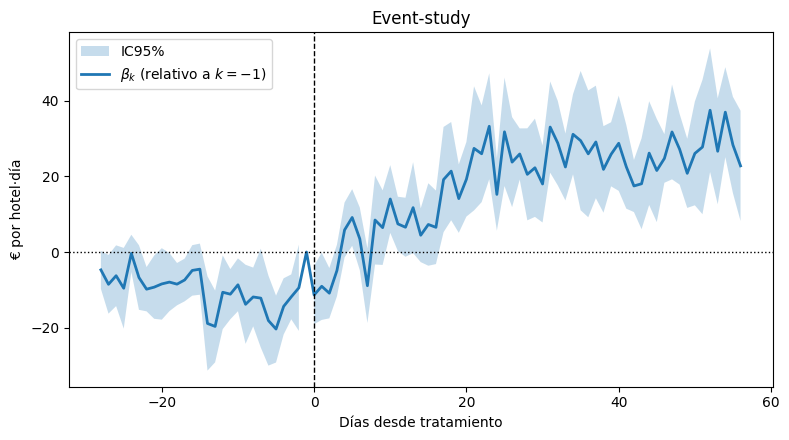

,beta,se,lo95,hi95
-28,-4.715111,2.559293,-9.731325,0.301103
-27,-8.524023,3.955272,-16.276356,-0.771691
-26,-6.257066,4.094936,-14.283141,1.769010
-25,-9.566405,5.440752,-20.230280,1.097469
-24,-0.355315,2.509461,-5.273858,4.563228
...,...,...,...,...
52,37.464576,8.328251,21.141204,53.787949
53,26.623692,7.144949,12.619592,40.627793
54,36.950593,6.063248,25.066626,48.834560
55,28.283499,6.491388,15.560378,41.006619


In [ ]:
# === 9) Event-study (TWFE, cluster por hotel) — versión sin errores de Patsy ===
import numpy as np, pandas as pd, statsmodels.formula.api as smf
import matplotlib.pyplot as plt

K_PRE, K_POST = 28, 56

# 1) Tiempo relativo al tratamiento (si ya lo tienes en 'event_time', conserva esa columna)
mad_ref = work.loc[work['treated']==1, 'treat_date'].median()
work = work.copy()
work['event_time'] = (work['date'] - mad_ref).dt.days.astype(int)

# 2) Dummies de evento SOLO para tratados; excluimos k = -1 (categoría base)
ks = [k for k in range(-K_PRE, K_POST+1) if k != -1]
ll = pd.get_dummies(work['event_time'])
ll = ll.reindex(columns=ks, fill_value=0)
ll = ll.mul(work['treated'].to_numpy()[:, None])     # interacción con tratado
ll.columns = [f'ev_{k}' for k in ks]                 # nombres (algunos con '-')

# 3) Ensamblar matriz y construir fórmula citando columnas con Q("...") para evitar la “resta”
X = pd.concat([work[['hotel_id','date','margin','weight']], ll], axis=1, copy=False)
ev_terms = ' + '.join([f'Q("{c}")' for c in ll.columns])   # <<< CITA CADA NOMBRE
formula = f'margin ~ {ev_terms} + C(hotel_id) + C(date)'

# 4) Ajuste WLS con errores cluster por hotel
res = smf.wls(formula, data=X, weights=X['weight']).fit(
    cov_type='cluster', cov_kwds={'groups': X['hotel_id']}
)

# 5) Extraer coeficientes β_k y se_k; reconstruir índice completo e insertar k = -1 = 0
def _col_from_term(term):
    # Statsmodels devolverá nombres tipo Q("ev_-28")
    return term.split('"')[1] if term.startswith('Q("') else term

params_ev = { _col_from_term(k): v for k, v in res.params.items() if 'ev_' in k }
bse_ev    = { _col_from_term(k): v for k, v in res.bse.items()    if 'ev_' in k }

beta = pd.Series(params_ev, dtype=float)
se   = pd.Series(bse_ev,    dtype=float)

# Mapea 'ev_{k}' -> k
beta.index = beta.index.str.split('_').str[1].astype(int)
se.index   = se.index.str.split('_').str[1].astype(int)

full_index = pd.Index(range(-K_PRE, K_POST+1), dtype=int)
beta = beta.reindex(full_index)
se   = se.reindex(full_index)

beta.loc[-1] = 0.0  # referencia
# se en -1 queda NaN (no se estima). Cálculo de bandas:
lo = beta - 1.96*se
hi = beta + 1.96*se

# 6) Gráfico
plt.figure(figsize=(8,4.5))
x = beta.index.values
plt.fill_between(x, lo.values, hi.values, alpha=0.25, label='IC95%')
plt.plot(x, beta.values, lw=2, label=r'$\beta_k$ (relativo a $k=-1$)')
plt.axvline(0, ls='--', lw=1, color='k'); plt.axhline(0, ls=':', lw=1, color='k')
plt.title('Event-study')
plt.xlabel('Días desde tratamiento'); plt.ylabel('€ por hotel·día')
plt.legend(); plt.tight_layout(); plt.show()

# 7) (Opcional) tabla ordenada
tabla_ev = pd.DataFrame({'beta': beta, 'se': se, 'lo95': lo, 'hi95': hi})
display(tabla_ev.loc[range(-K_PRE, K_POST+1)])


## 10) Donut, placebo, leave‑one‑city‑out...

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# --- COPIA Y LIMPIEZA BÁSICA ---
df = df.copy()
df['date'] = pd.to_datetime(df['date'])

# Si todos los tratados cambian el mismo día, podemos inferir:
treat_date = df.loc[df['D'] == 1, 'date'].min()

# Marcamos qué hoteles están alguna vez tratados (1 si D=1 en algún día)
df['treated'] = df.groupby('hotel_id')['D'].transform('max').fillna(0).astype(int)

def fit_twfe(data, y='margin', x='D'):
    """TWFE: y ~ x + occ + adr + FE hotel + FE fecha, SEs cluster por hotel."""
    use = data[[y, x, 'occ', 'adr', 'hotel_id', 'date']].dropna().copy()
    formula = f"{y} ~ {x} + occ + adr + C(hotel_id) + C(date)"
    res = smf.ols(formula, data=use).fit(cov_type='cluster',
                                         cov_kwds={'groups': use['hotel_id']})
    return res

def show(res, name, x):
    b  = res.params.get(x, np.nan)
    se = res.bse.get(x, np.nan)
    p  = res.pvalues.get(x, np.nan)
    n  = int(res.nobs)
    h  = res.model.data.frame['hotel_id'].nunique()
    t  = res.model.data.frame['date'].nunique()
    print(f"{name}: {x} = {b:,.2f}  (se {se:,.2f}, p={p:,.3g}) | N={n}, hoteles={h}, días={t}")

# ==== 1) ESTIMACIÓN PRINCIPAL ====
res_main = fit_twfe(df, y='margin', x='D')
show(res_main, 'TWFE principal', 'D')

# ==== 2) DONUT (excluir ventana alrededor del arranque real) ====
donut_days = 3  # ajusta si quieres (p.ej., 7)
mask_donut = (df['date'] < treat_date - pd.Timedelta(days=donut_days)) | \
             (df['date'] > treat_date + pd.Timedelta(days=donut_days))
res_donut = fit_twfe(df.loc[mask_donut], y='margin', x='D')
show(res_donut, f"Donut (±{donut_days} días)", 'D')

# ==== 3) PLACEBO TEMPORAL “LIMPIO” (solo PRE) ====
# Definimos D_p = 1 SOLO para hoteles tratados y SOLO en los 30 días ANTES del cambio.
placebo_window = 30  # días
pre = df.loc[df['date'] < treat_date].copy()
pre['D_p'] = (
    (pre['treated'] == 1) &
    (pre['date'].between(treat_date - pd.Timedelta(days=placebo_window),
                         treat_date - pd.Timedelta(days=1)))
).astype(int)

# Estimamos en pre-period; si no hay señal espuria, D_p ≈ 0 y no significativo.
res_placebo = fit_twfe(pre, y='margin', x='D_p')
show(res_placebo, f"Placebo pre ({placebo_window}d antes)", 'D_p')

# ==== 4) LEAVE-ONE-CITY-OUT (ejemplo: quitar Zaragoza) ====
city_to_drop = 'Zaragoza'
if 'city' in df.columns:
    df_loco = df.loc[df['city'] != city_to_drop].copy()
    res_loco = fit_twfe(df_loco, y='margin', x='D')
    show(res_loco, f"Leave-one-city-out (sin {city_to_drop})", 'D')
else:
    print("Leave-one-city-out: columna 'city' no existe en df; saltando esta prueba.")


TWFE principal: D = 27.28  (se 3.97, p=6.55e-12) | N=18400, hoteles=100, días=184
Donut (±3 días): D = 28.61  (se 4.17, p=6.89e-12) | N=17700, hoteles=100, días=177
Placebo pre (30d antes): D_p = -4.02  (se 1.43, p=0.00512) | N=10600, hoteles=100, días=106
Leave-one-city-out (sin Zaragoza): D = 26.53  (se 4.00, p=3.45e-11) | N=15640, hoteles=85, días=184


## 11) Checks (`occ` y `adr` como outcomes)

In [ ]:
for outc in ['occ','adr']:
    f=smf.wls(f'{outc} ~ D + C(hotel_id) + C(date)', data=work, weights=work['weight']).fit(
        cov_type='cluster', cov_kwds={'groups': work['hotel_id']})
    print(f'\nOutcome = {outc}\n', f.summary().tables[1])

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 283, but rank is 99
  warnings.warn('covariance of constraints does not have full '



Outcome = occ
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.6234      0.003    208.061      0.000       0.617       0.629
C(hotel_id)[T.H002]                            -0.0070   8.09e-15  -8.66e+11      0.000      -0.007      -0.007
C(hotel_id)[T.H003]                             0.0408   3.57e-15   1.14e+13      0.000       0.041       0.041
C(hotel_id)[T.H004]                             0.0210   1.18e-14   1.78e+12      0.000       0.021       0.021
C(hotel_id)[T.H005]                            -0.0400   6.85e-15  -5.84e+12      0.000      -0.040      -0.040
C(hotel_id)[T.H006]                            -0.0224   4.31e-15  -5.19e+12      0.000      -0.022      -0.022
C(hotel_id)[T.H007]                             0.0129   6.34e-15   2.04e+12      0.000  

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 283, but rank is 99
  warnings.warn('covariance of constraints does not have full '


In [ ]:
for outc in ['occ','adr']:
    m = smf.wls(f'{outc} ~ D + C(hotel_id) + C(date)',
                data=work, weights=work['weight']) \
           .fit(cov_type='cluster', cov_kwds={'groups': work['hotel_id']})
    print(f"{outc}: D = {m.params['D']:.3f} (se {m.bse['D']:.3f}, p={m.pvalues['D']:.3g})")


occ: D = 0.000 (se 0.001, p=0.957)
adr: D = 0.029 (se 0.103, p=0.779)


## 12) Factual vs. contrafactual

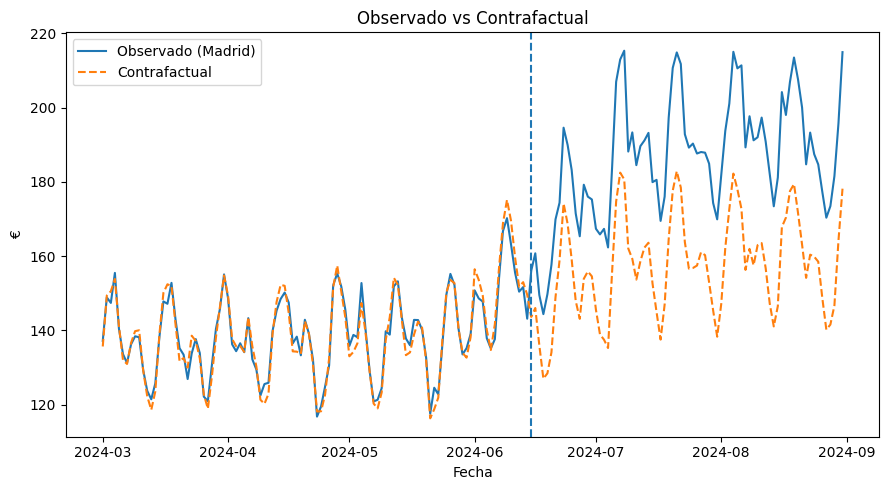

ATT medio post (€/hotel·día): 29.08302029633155


In [ ]:
treated_post=work['treated'].eq(1) & work['D'].eq(1)
pred=twfe.predict(work)
cf=work.copy(); cf.loc[treated_post, 'D']=0
pred_cf=twfe.predict(cf)
agg=(work[work['treated']==1].assign(yh=pred, yh_cf=pred_cf)
     .groupby('date', as_index=False).agg(actual=('margin','mean'), cf=('yh_cf','mean')))
agg['att_t']=agg['actual']-agg['cf']
plt.figure(); plt.plot(agg['date'], agg['actual'], label='Observado (Madrid)');
plt.plot(agg['date'], agg['cf'], linestyle='--', label='Contrafactual');
plt.axvline(ref_date, linestyle='--'); plt.title('Observado vs Contrafactual');
plt.xlabel('Fecha'); plt.ylabel('€'); plt.legend(); plt.tight_layout(); plt.show()
print('ATT medio post (€/hotel·día):', agg.loc[agg['date']>=ref_date,'att_t'].mean())